In [1]:
import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from scipy.stats import gaussian_kde
import scipy
import scipy.sparse
import patsy
from statistics import median
import bz2
import math

In [2]:
model_dir = '/Users/katew/Downloads/'

def sort_cols(test): 
    return(test.reindex(sorted(test.columns), axis=1))

frames = {}
for year in [2004,2005,2006]:
    fil = model_dir + "pandas-frames." + str(year) + ".pickle.bz2"
    frames.update(pd.read_pickle(fil))
for x in frames: 
    frames[x] = sort_cols(frames[x])
    
covariance = {}
for year in [2003,2004,2005,2006]:
    fil = model_dir + "covariance." + str(year) + ".pickle.bz2"
    covariance.update(pd.read_pickle(fil))

In [3]:
industry_factors = ['AERODEF', 'AIRLINES', 'ALUMSTEL', 'APPAREL', 'AUTO',
'BANKS','BEVTOB', 'BIOLIFE', 'BLDGPROD','CHEM', 'CNSTENG',
'CNSTMACH', 'CNSTMATL', 'COMMEQP', 'COMPELEC',
'COMSVCS', 'CONGLOM', 'CONTAINR', 'DISTRIB',
'DIVFIN', 'ELECEQP', 'ELECUTIL', 'FOODPROD', 'FOODRET', 'GASUTIL',
'HLTHEQP', 'HLTHSVCS', 'HOMEBLDG', 'HOUSEDUR','INDMACH', 'INSURNCE','INTERNET',
'LEISPROD', 'LEISSVCS', 'LIFEINS', 'MEDIA', 'MGDHLTH','MULTUTIL',
'OILGSCON', 'OILGSDRL', 'OILGSEQP', 'OILGSEXP',
'PAPER', 'PHARMA', 'PRECMTLS','PSNLPROD','REALEST',
'RESTAUR', 'ROADRAIL','SEMICOND', 'SEMIEQP','SOFTWARE',
'SPLTYRET', 'SPTYCHEM', 'SPTYSTOR', 'TELECOM', 'TRADECO', 'TRANSPRT','WIRELESS']

style_factors = ['BETA','SIZE','MOMENTUM','VALUE','LEVERAGE','LIQUIDTY']

In [4]:
def wins(x,a,b):
    return(np.where(x <= a,a, np.where(x >= b, b, x)))
    
def clean_nas(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    for numeric_column in numeric_columns:
        df[numeric_column] = np.nan_to_num(df[numeric_column])
        
    return df

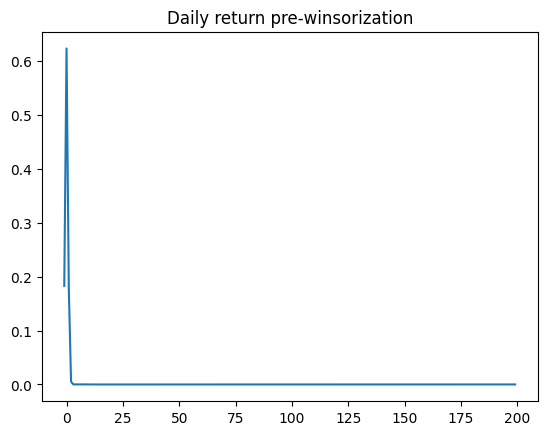

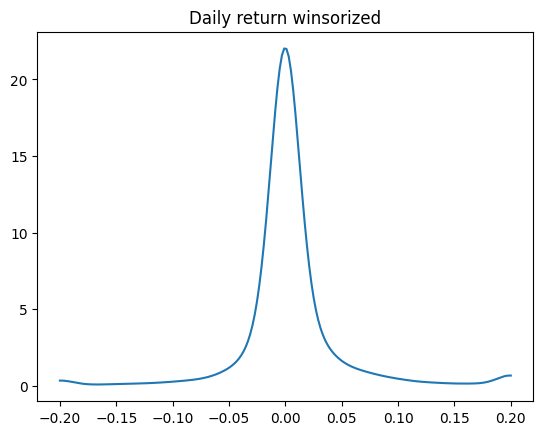

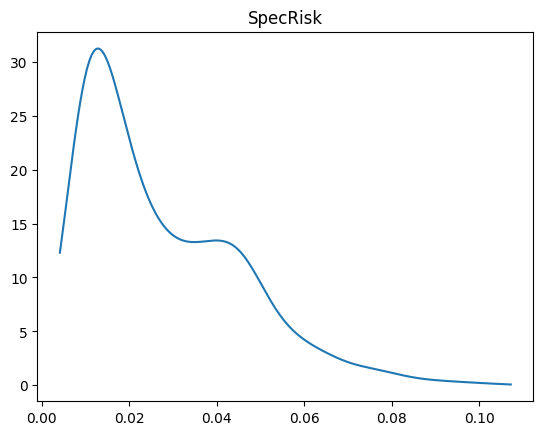

In [5]:
def density_plot(data, title):
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data),np.max(data),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs))
    plt.title(title)
    plt.show()
    
test = frames['20040102']
density_plot(test['Ret'], 'Daily return pre-winsorization')
density_plot(wins(test['Ret'],-0.2,0.2), 'Daily return winsorized')

D = (test['SpecRisk'] / (100 * math.sqrt(252))) ** 2
density_plot(np.sqrt(D), 'SpecRisk')


In [6]:
def get_estu(df):
    """Estimation universe definition"""
    estu = df.loc[df.IssuerMarketCap > 1e9].copy(deep=True)
    return estu
    
def colnames(X):
    """ return names of columns, for DataFrame or DesignMatrix """
    if(type(X) == patsy.design_info.DesignMatrix):
        return(X.design_info.column_names)
    if(type(X) == pandas.core.frame.DataFrame):
        return(X.columns.tolist())
    return(None)

def diagonal_factor_cov(date, X):
    """
    Compute the diagonal factor covariance matrix and ensure it is returned as a DataFrame.
    """
    cv = covariance[date]  # Assume covariance is a dictionary keyed by date
    k = np.shape(X)[1]  # Number of factors
    Fm = np.zeros([k, k])  # Initialize matrix

    factor_names = colnames(X)
    for j in range(k):
        fac = factor_names[j]
        if ((cv['Factor1'] == fac) & (cv['Factor2'] == fac)).sum() == 0:
            #print(f"Factor {fac} not found in covariance matrix. Setting variance to zero.")
            Fm[j, j] = 0  # Default to zero if the factor is missing
        else:
            Fm[j, j] = (0.01**2) * cv.loc[
                (cv.Factor1 == fac) & (cv.Factor2 == fac), "VarCovar"
            ].iloc[0]

    # Convert Fm to a DataFrame with factor names
    F = pd.DataFrame(Fm, index=factor_names, columns=factor_names)
    return F
    
def risk_exposures(estu):
    """Exposure matrix for risk factors, usually called X in class"""
    L = ["0"]
    L.extend(style_factors)
    L.extend(industry_factors)
    my_formula = " + ".join(L)
    return patsy.dmatrix(my_formula, data = estu)

In [7]:
my_date = '20040102'

# estu = estimation universe
estu = get_estu(frames[my_date])
estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)

rske = risk_exposures(estu)
F = diagonal_factor_cov(my_date, rske)
X = np.asarray(rske)
D = np.asarray( (estu['SpecRisk'] / (100 * math.sqrt(252))) ** 2 )

kappa = 1e-5

candidate_alphas = [
'STREVRSL', 'LTREVRSL', 'INDMOM',
'EARNQLTY', 'EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']

### Problem 0

In [8]:
def filter_estimation_universe(frames):
    for date, frame in frames.items():
        frames[date] = frame.loc[frame['IssuerMarketCap'] > 1e9].copy()
    return frames

# Filter the frames
frames = filter_estimation_universe(frames)

### Problem 1

In [9]:
from numpy.linalg import pinv

def compute_residual_returns(frames, covariance):
    """Compute residual returns and add as a new column Y."""
    for date, frame in frames.items():
        estu = frame.copy()
        estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)  # Winsorize returns
        X = np.asarray(risk_exposures(estu))
        pseudo_inverse = pinv(X)
        residuals = frame['Ret'].values - X @ (pseudo_inverse @ frame['Ret'].values)
        frame['Y'] = residuals
    return frames

# Add residuals to frames
frames = compute_residual_returns(frames, covariance)

In [10]:
from numpy.linalg import pinv

# Compute pseudoinverse residual
def residuals(frame, risk_matrix):
    """Compute residuals (Y): Y = Ret - X @ X+ @ Ret"""
    # Convert risk exposure matrix to NumPy array
    X = np.asarray(risk_matrix)
    
    # Compute pseudoinverse of X
    X_pinv = pinv(X)
    
    # Get winsorized Ret column
    Ret_wins = wins(frame['Ret'], -0.25, 0.25)
    
    # Compute Y = Ret - X @ X_pinv @ Ret
    residuals = Ret_wins - X @ (X_pinv @ Ret_wins)
    
    # Add residuals as a new column
    frame['Residuals'] = residuals
    return frame

# Filter estimation universe and compute residuals for each frame
for date, frame in frames.items():
    # Use the function from prior code to estimate universe
    estu = get_estu(frame)
    
    # Winsorize the Ret column
    estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)
    
    # Get risk exposures for the estimation universe
    risk_matrix = risk_exposures(estu)  
    
    # Compute and add residuals to the data frame
    frames[date] = residuals(estu, risk_matrix)  


### Problem 2

In [11]:
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Combine frames into a single panel for training
panel = pd.concat(frames.values(), ignore_index=True)

# Define candidate alpha factors
candidate_alphas = ['STREVRSL', 'LTREVRSL', 'INDMOM', 'EARNQLTY', 'EARNYILD', 
                    'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']

# Training/test split
train, test = train_test_split(panel, test_size=0.2, random_state=42)

# Random Forest
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(train[candidate_alphas], train['Y'])

RandomForestRegressor(random_state=42)

In [12]:
from sklearn.metrics import mean_squared_error, r2_score

# Predictions on the test set
random_forest_preds = random_forest.predict(test[candidate_alphas])

# Random Forest metrics
random_forest_mse = mean_squared_error(test['Y'], random_forest_preds)
random_forest_r2 = r2_score(test['Y'], random_forest_preds)

print("\nRandom Forest Performance:")
print(f"MSE: {random_forest_mse:.4f}")
print(f"R²: {random_forest_r2:.4f}")



Random Forest Performance:
MSE: 0.0005
R²: -0.3980


In [13]:
from xgboost import XGBRegressor

# Gradient Boosting (XGBoost)
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb.fit(train[candidate_alphas], train['Y'])

# Predictions
xgb_preds = xgb.predict(test[candidate_alphas])

# Metrics
xgb_mse = mean_squared_error(test['Y'], xgb_preds)
xgb_r2 = r2_score(test['Y'], xgb_preds)

print("\nXGBoost Performance:")
print(f"MSE: {xgb_mse:.4f}")
print(f"R²: {xgb_r2:.4f}")


XGBoost Performance:
MSE: 0.0004
R²: -0.1040


In [14]:
from sklearn.model_selection import train_test_split

# Convert frames dictionary into list
data = list(frames.items())

# Split data by dates
train, test = train_test_split(data, test_size=0.2, random_state=42)

# Reconstruct D_train and D_test as dictionaries
D_train = {date: frame for date, frame in train}
D_test = {date: frame for date, frame in test}

# Join all frames in D_train into a panel
panel = pd.concat(D_train.values(), ignore_index=True)

In [15]:
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Extract alpha factors and residuals 
X = panel[candidate_alphas]
y = panel['Residuals']

# Try Elastic Net with cross-validation
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ElasticNetCV(cv=5, random_state=42))  
])

pipeline.fit(X, y)

# Cross-validation score
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
print("ElasticNet CV Mean MSE:", -cv_scores.mean())


ElasticNet CV Mean MSE: 0.0002804307760543783


In [17]:
# Extract the fitted ElasticNetCV model from the pipeline
fitted_elastic_net = pipeline.named_steps['model']

# Get the coefficients of the ElasticNetCV model
coefficients = fitted_elastic_net.coef_

# Create a DataFrame to visualize the alpha factors and their corresponding coefficients
alpha_importance = pd.DataFrame({
    'Alpha Factor': candidate_alphas,
    'Coefficient': coefficients
})

# Sort by absolute coefficient values (most important factors first)
alpha_importance = alpha_importance.reindex(alpha_importance.Coefficient.abs().sort_values(ascending=False).index)

print(alpha_importance)

  Alpha Factor  Coefficient
0     STREVRSL     0.000220
7       SEASON     0.000090
4     EARNYILD     0.000086
8       SENTMT     0.000063
2       INDMOM     0.000038
6       PROFIT     0.000014
3     EARNQLTY    -0.000005
5     MGMTQLTY     0.000001
1     LTREVRSL    -0.000000


In [18]:
from sklearn.linear_model import RidgeCV

# Try Ridge regression with cross-validation
ridge = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)
ridge.fit(panel[candidate_alphas], panel['Residuals'])

ridge_score = ridge.score(panel[candidate_alphas], panel['Residuals'])
print("R²:", ridge_score)


R²: 0.000275713882867179


In [19]:
# Get the coefficients
ridge_coefficients = ridge.coef_

# Create a DataFrame to visualize the alpha factors and their coefficients
ridge_importance = pd.DataFrame({
    'Alpha Factor': candidate_alphas,
    'Coefficient': ridge_coefficients
})

# Sort by absolute coefficient values (most important factors first)
ridge_importance = ridge_importance.reindex(ridge_importance.Coefficient.abs().sort_values(ascending=False).index)

print(ridge_importance)

  Alpha Factor  Coefficient
0     STREVRSL     0.000237
7       SEASON     0.000104
4     EARNYILD     0.000097
8       SENTMT     0.000079
2       INDMOM     0.000042
6       PROFIT     0.000025
3     EARNQLTY    -0.000016
5     MGMTQLTY     0.000013
1     LTREVRSL    -0.000006


In [20]:
from sklearn.neural_network import MLPRegressor

# Try Neural Network with hyperparameter tuning
mlp = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42, max_iter=500)
mlp.fit(X, y)

mlp_cv_scores = cross_val_score(mlp, X, y, cv=5, scoring='neg_mean_squared_error')
print("Neural Network MSE:", -mlp_cv_scores.mean())


Neural Network MSE: 0.0002807045212236678


### Problem 3

In [30]:
def eff_optimization_woodbury(mu, cov_base, target_return, U, C):
    n = len(mu)  # Number of assets
    ones = np.ones(n)

    # Apply the Woodbury lemma to invert the covariance matrix
    sigma2_I_inv = np.linalg.inv(cov_base)

    # Regularize C to avoid singular matrix error
    epsilon = 1e-6  # Small regularization value
    if np.linalg.matrix_rank(C) < C.shape[0]:
        C = C + epsilon * np.eye(C.shape[0])

    C_inv = np.linalg.inv(C)
    cov_inv = sigma2_I_inv - sigma2_I_inv @ U @ np.linalg.inv(C_inv + U.T @ sigma2_I_inv @ U) @ U.T @ sigma2_I_inv

    # Calculate helper values
    A = ones.T @ cov_inv @ ones
    B = ones.T @ cov_inv @ mu
    C_val = mu.T @ cov_inv @ mu

    # Calculate Lagrange multipliers
    lambda_ = (C_val - target_return * B) / (A * C_val - B ** 2)
    gamma = (target_return * A - B) / (A * C_val - B ** 2)

    # Compute weights
    weights = lambda_ * cov_inv @ ones + gamma * cov_inv @ mu

    return weights

### Problem 4

In [22]:
import matplotlib.pyplot as plt

def backtest_portfolio(frames, alpha_name, covariance, target_return=0.02):
    cumulative_profit = []
    long_market_value = []
    short_market_value = []
    daily_risk = []
    idiosyncratic_risk_pct = []

    total_profit = 0

    for date, frame in frames.items():
        estu = frame.copy()

        # Get risk exposures
        X = risk_exposures(estu)
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=estu.columns[:X.shape[1]])

        # Compute covariance matrix
        F = diagonal_factor_cov(date, X)
        D = np.asarray((estu['SpecRisk'] / (100 * np.sqrt(252))) ** 2)

        # Alpha factor (expected returns)
        alpha = estu[alpha_name].values

        # Apply the eff_optimization_woodbury function for portfolio weights
        weights = eff_optimization_woodbury(
            mu=alpha,
            cov_base=np.diag(D),  # Base covariance matrix
            target_return=target_return,
            U=X.values,  # Factor exposures
            C=F  # Factor covariance
        )

        # Calculate daily profit
        daily_profit = np.dot(weights, estu['Ret'].values)
        cumulative_profit.append(total_profit + daily_profit)
        total_profit += daily_profit

        # Compute long and short market values
        long_market_value.append(weights[weights > 0].sum())
        short_market_value.append(abs(weights[weights < 0].sum()))

        # Compute full covariance matrix
        full_cov_matrix = X @ F @ X.T + np.diag(D)

        # Calculate risk
        portfolio_var = weights.T @ full_cov_matrix @ weights
        specific_var = weights.T @ np.diag(D) @ weights
        daily_risk.append(np.sqrt(portfolio_var))
        idiosyncratic_risk_pct.append((specific_var / portfolio_var) * 100)

    return {
        "cumulative_profit": cumulative_profit,
        "long_market_value": long_market_value,
        "short_market_value": short_market_value,
        "daily_risk": daily_risk,
        "idiosyncratic_risk_pct": idiosyncratic_risk_pct,
    }

In [31]:
# Run the backtest
results = backtest_portfolio(frames, 'STREVRSL', covariance)

# Extract results
dates = pd.to_datetime(list(frames.keys()), format='%Y%m%d')
cumulative_profit = results['cumulative_profit']
long_market_value = results['long_market_value']
short_market_value = results['short_market_value']
daily_risk = results['daily_risk']
idiosyncratic_risk_pct = results['idiosyncratic_risk_pct']

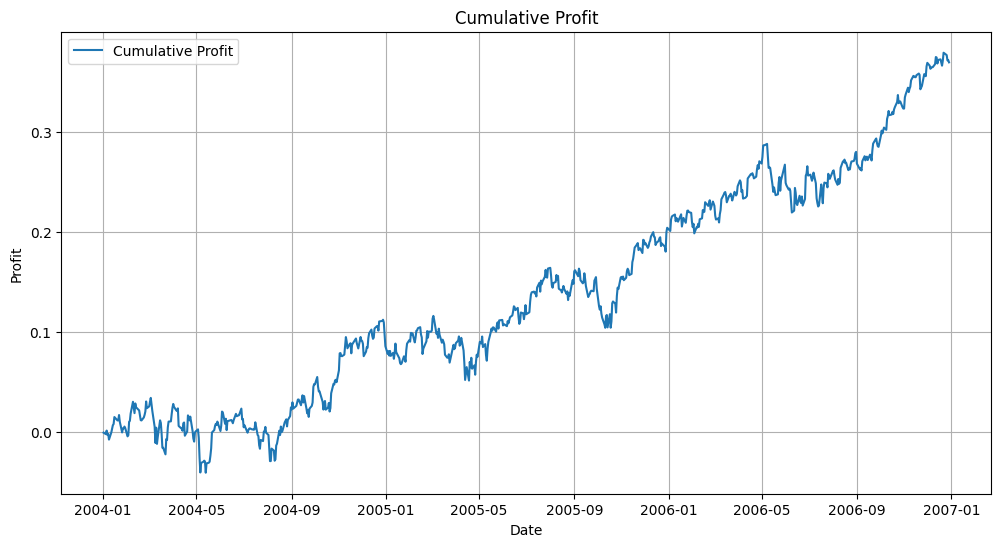

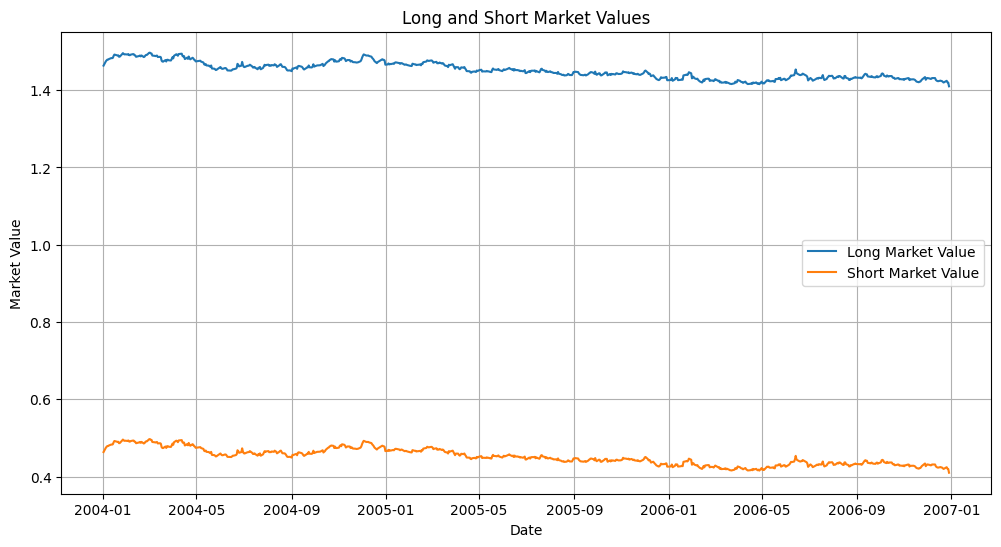

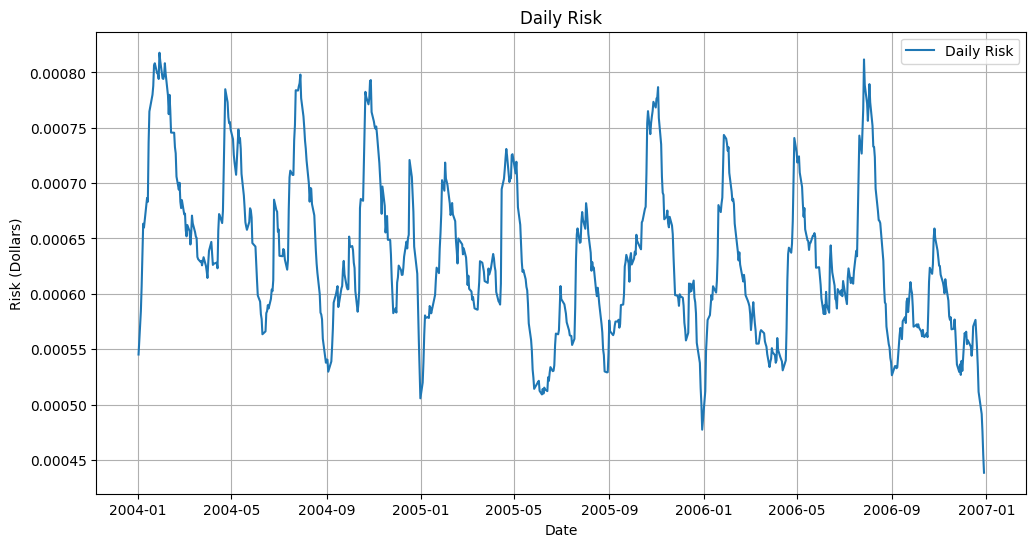

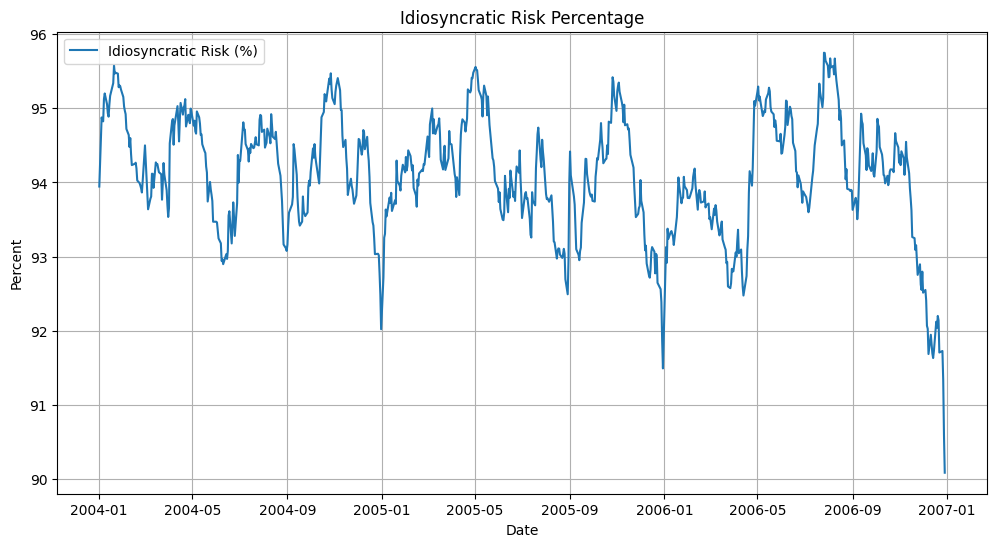

In [27]:
# Plot cumulative profit
plt.figure(figsize=(12, 6))
plt.plot(dates, cumulative_profit, label='Cumulative Profit')
plt.title('Cumulative Profit')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
plt.grid()
plt.show()

# Plot long and short market values
plt.figure(figsize=(12, 6))
plt.plot(dates, long_market_value, label='Long Market Value')
plt.plot(dates, short_market_value, label='Short Market Value')
plt.title('Long and Short Market Values')
plt.xlabel('Date')
plt.ylabel('Market Value')
plt.legend()
plt.grid()
plt.show()

# Plot daily risk
plt.figure(figsize=(12, 6))
plt.plot(dates, daily_risk, label='Daily Risk')
plt.title('Daily Risk')
plt.xlabel('Date')
plt.ylabel('Risk (Dollars)')
plt.legend()
plt.grid()
plt.show()

# Plot percent idiosyncratic risk
plt.figure(figsize=(12, 6))
plt.plot(dates, idiosyncratic_risk_pct, label='Idiosyncratic Risk (%)')
plt.title('Idiosyncratic Risk Percentage')
plt.xlabel('Date')
plt.ylabel('Percent')
plt.legend()
plt.grid()
plt.show()